<a id='top'></a>
<h1 align="center">MCMC Tutorial Chapter 3</h1>

<br>

**Authors:** Mingxuan Zhang, John Letey, and Tony E. Wong

<span style="color:gray">**TW:**
My perception is that this ordering of authors accurately reflects the relative contributions?
</span>

<span style="color:blue">**JL:** Correct ... DONE</span>

Storm surge is a big problem in coastal regions, it is a threat to people's life and property. The coastal flood defences may be the most important way to protect the coastal regions, for coastal flood defences an important information we need to know might be what storm surge heights are expected with what return periods. In pratice the GEV distribution is a poweful tool to estimate storm surge return levels, to do so we will have to fit the storm surge data set with GEV distribution, this is exactly the same as what we have done in Chapter2B, we will use Metropolis-Hastings algoritm to estimate the three parameters from GEV distribution which are $\mu$(location), $\sigma$(scale), $\xi$(shape). So instead of using synthetic data, we will use real data this time!


### Table of Contents

- [Packages and Helper Functions](#packages)
- [Data Preprocessing](#data-cleaning)
- [Running the Algorithm](#running-algo)
- [History Plots For Each Parameter](#history-plots)
- [Gelman-Rubin Diagnostic Results](#gr-diagnostic)
- [Auto Correlation Function Results](#ac-function)
- [Histograms For Each Parameter](#histograms)
- [Max Log-Posterior Score Parameter Set](#max-ls)
- [Diagnostic Plots](#diag-plots)

# Important!

Since we are using all the same stuff (log-posterior, Metroplois-Hastings algorithm, GR, thinning) from Chapter 2B, so we included all of them in Packages and Helper Functions section, so go to that section and run the cell first, then come back here!

***

<a id='data-cleaning'></a>
***
<h2 align="center">Data Preprocessing</h2>

[Back to top](#top)

<br>

For this tutorial, the sea level data set we are going to analyze is from [The University of Hawaii Sea-Level Center](https://uhslc.soest.hawaii.edu).


Before we start, we have to do some data preprocessing, since it is typical to have missing values for these kind of data sets, and usually people will use fill-in values for these missing data. Therefore, we have to find the fill-in value, and drop all of them, also we're going to give the columns more meaningful names.

First, let's take a look at the first few rows of the data set, to do this, we have to read in the data set first (note that the format of this data set is csv), and we will work with the library called pandas. Pandas is a powerful library for data analysis in Python, it works great with data sets in csv format, and you can find the tutorial for Pandas [here](http://pandas.pydata.org/pandas-docs/version/0.15/tutorials.html). 

To read in csv file we can use the function [pd.read_csv()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) in pandas, then we can rename the columns with function [rename()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.rename.html).

<span style='color:gray'>**TW:**
Need to include the Galveston.csv data file somewhere. Best practice is probably to give options for both (1) reading the CSV remotely, straight from the URL linked to the UHSLC data repository, and (2) downloading the file and reading locally. I would keep the same name as the default from UHSLC ("rhqXXXX.csv" or something like that)
<span>
    
<span style="color:blue">**JL:** DONE</span>

In [2]:
# data-paths
local_path = "../data/h775.csv"
web_path = "http://uhslc.soest.hawaii.edu/data/csv/fast/hourly/h775.csv"
# read in the data set
dfSL = pd.read_csv(local_path, header=None)
# rename the columns
dfSL.rename(columns={0:'year',1:'month', 2:'day', 3:'hour', 4: 'sealevel'}, inplace=True)
# show the first rows
dfSL.head()

,year,month,day,hour,sealevel
0,1904,1,1,6,961
1,1904,1,1,7,992
2,1904,1,1,8,961
3,1904,1,1,9,900
4,1904,1,1,10,809


***

<br>

Now, let's find out what is the fill-in value for this data set!

In real world, a 5 meter trough (which means the sea level is negative 5 meter) would be just unheardof, even in the time just before a tsunami, so we will group all sea level values that are less than $-5000$ millimeters by using the built-in DataFrame method [loc](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.loc.html) in Pandas, then we can get the fill-in value by finding the mode of that group, since we only have one fill-in value, we will have a lot of repeating values.

Note that, the units for the sea level of this data set is **millimeters**. If you are using other data sets, make sure you are working with correct units.

In [3]:
fill_in = dfSL.loc[dfSL['sealevel'] < -5000, "sealevel"].mode()[0]
print ('The fill in value is {0}'.format(fill_in))

The fill in value is -32767


***

Now that we have the fill-in value, we can drop all of them!

First, we will replace the value in sea level column with **NaN** for the rows whose sea level value is equal to fill in value we just found above, we can do this easily with the DataFrame method [replace()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) in Pandas. Here NaN indicates the value of sea level column is missing.

Then we can use the [dropna()](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.dropna.html) method, which will drop all the rows whose value in sea level column is NaN.

After this, we can plot the data set, note that the scale of x-axis is relative to the beginning time of the data set, it is 01/01/1904 at 6am, in our case.

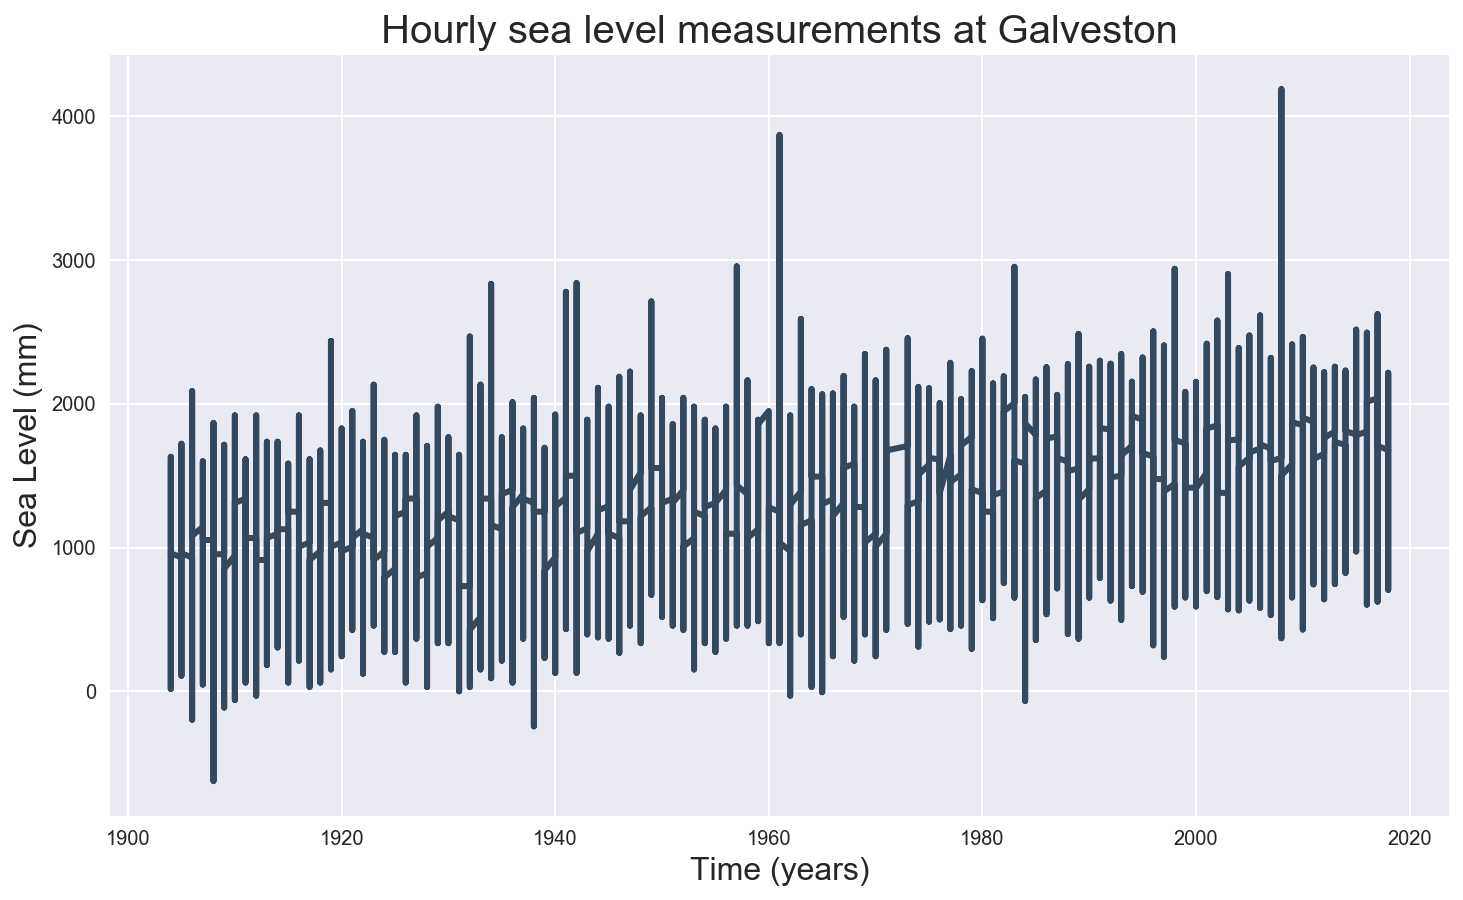

In [8]:
# replace the fill-in value with NaN
dfSL['sealevel'].replace(fill_in, np.nan, inplace=True)

# drop all NaN rows
dfSL.dropna(inplace= True)

# plot the data after dropping the rows
plt.figure(figsize=(12, 7))
plt.plot(dfSL["year"], dfSL['sealevel'],"#34495e", lw=3)
plt.title('Hourly sea level measurements at Galveston', fontsize=20)
plt.xlabel('Time (years)',  fontsize=16)
plt.ylabel('Sea Level (mm)',  fontsize=16)
plt.show()

<span style='color:gray'>**TW:**
these units of time are not particularly meaningful. are those actually the number of hours since 06:00 on 1/1/1904? or just the indices from the data frame?
$$$$
my suggestion is to either convert them to years, from 1904 to 2018 (or whenever the last year is). So 365*24 data points nominally will all have the same year, but the time axis here will be much cleaner and more meaningful. You don't need to say much about this in the text, but put a comment in the codes
<span>
    
<span style='color:blue'>**JL:** DONE</span>

***

<span style="color:red">**TW:**
it is worth it here to review *why* we want the annual maximum sea levels.  Which is because they should follow a GEV distribution, which we learned how to fit in Chapter 2... and should cite Coles 2001 here. $$$$
And keep in mind that some people will use longer or shorter blocks than 1 year. So block maxima approach does not necessarily mean we use 1 year. We use 1 year blocks because that smooths out sub-annual cycles like tides and seasonal cycles. $$$$
Suggested re-write outline for this block is below.$$$$
First, we want to analyze the height of the storm surge, so we must eliminate the effect that comes from the fact that the mean sea level is rising over time... (then you can go ahead and show a block of code that subtracts this) $$$$
Then, in order to fit a GEV distribution (references back to Ch 2), we need to take block maxima. We will use annual blocks because this smooths out things like seasonal and tidal cycles. So we... (then you can go ahead and show a block of code that constructs the time series of annual block maxima from the detrended hourly data set)
</span>

What we really want are the maximum sea levels for each year at Galveston. But first it is important to know that there are cycles and dependencies within the data that will introduce biases if we are misisng too much data from a given year. That's because of how this block maxima approach works, where we are looking at the maximum of each 1-year block of hourly measurements. So, if we are missing too many data points, we are not going to have a representative sampling of the sea levels observed in that year. With that said, the threshold we will use here is that we will only use the years where we have at least 90% of the data points for that year.

Second, since we want to analyze the pure height of storm surge, we have to eliminate the effect that comes from the fact that the mean sea level is rising over time, which you can tell by taking a look at the plot above.

Finally, after the previous two steps, we can take the maximum for all available years!

In [5]:
# there are this many hours in a year
n_hours = 365*24

sl_year = {}

for index, row in dfSL.iterrows():
    year = row['year']
    sl = row['sealevel']
    if year in sl_year:
        sl_year[year].append(sl)
    else:
        sl_year[year] = []
        sl_year[year].append(sl)
        
max_sl = {}

for year, sealevel in sl_year.items():
    if len(sealevel)/n_hours >= 0.9:
        max_sl[year] = max(np.array(sealevel)-np.mean(sealevel))

***

Finally, we can take a look at the histogram of the annual maximum sea levels at Galveston! We can also figure out how many years of good data are available there, because in practice we want at least about 30 available years. With fewer annual block maxima than 30, it is difficult to constrain the GEV distribution parameters.

<span style="color:gray">**TW:**
suggested rewrite:  "... 30 available years. With fewer annual block maxima than 30, it is difficult to constrain the GEV distribution parameters." (or something like that)
</span>

<span style="color:blue">**JL:** DONE</span>

There are 104 years we can use



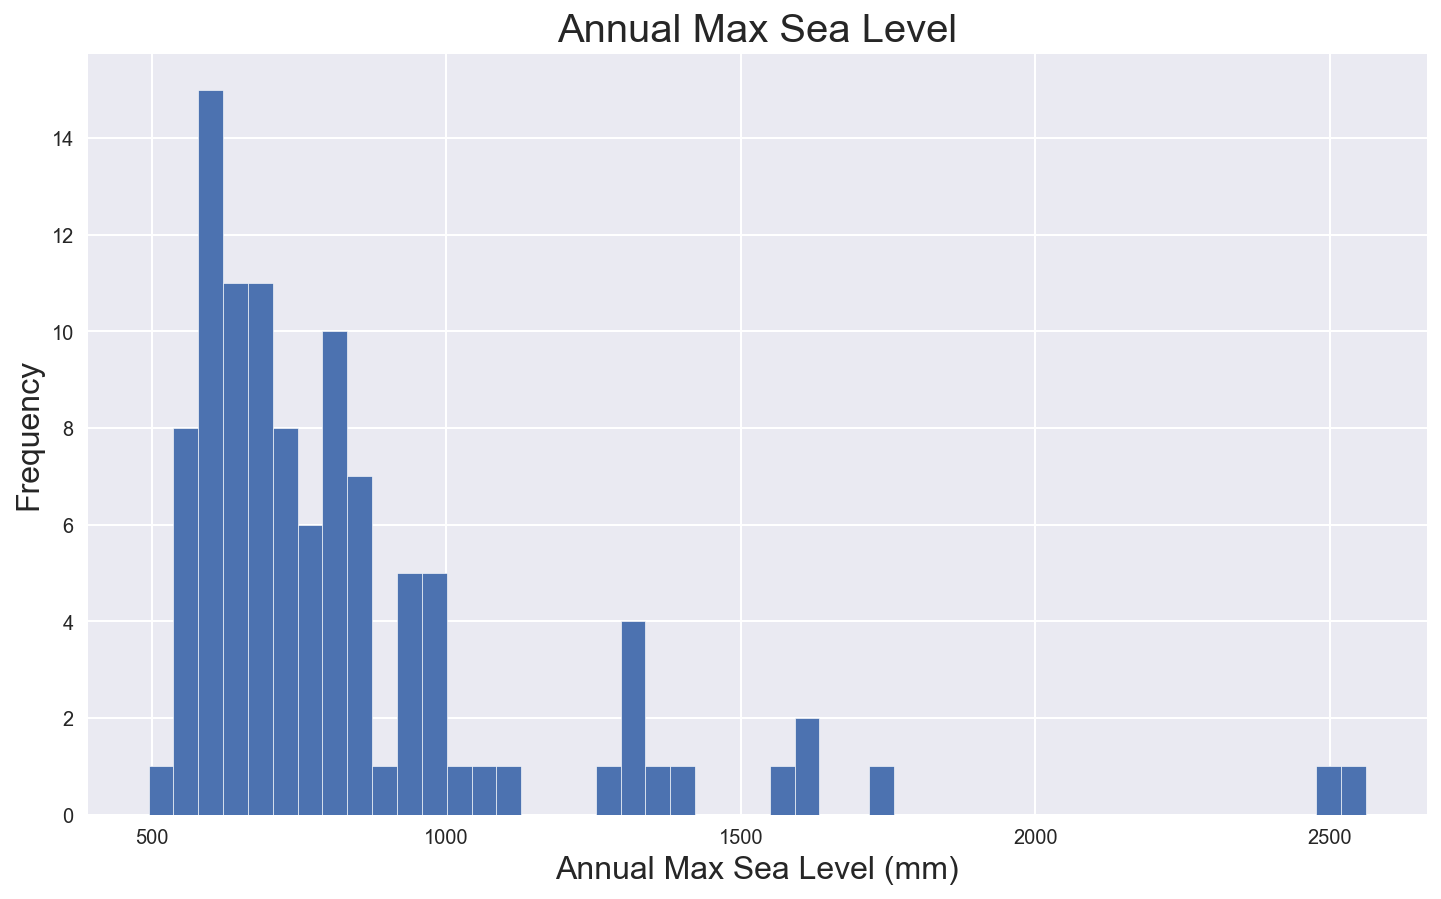

In [9]:
data_meas = list(max_sl.values())


print ('There are {0} years we can use'.format(len(data_meas)))
print ()

plt.figure(figsize=(12, 7))
plt.hist(x=data_meas, bins=np.linspace(min(data_meas), max(data_meas)), edgecolor='white')
plt.title('Annual Max Sea Level', fontsize=20)
plt.xlabel('Annual Max Sea Level (mm)', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

***

<a id='running-algo'></a>
***
<h2 align="center">Running the Algorithm</h2>

[Back to top](#top)

<br>

<span style="color:gray">**TW:**
made some edits below. see if you like them. Mainly, I want to use shorter sentences and speak less like reading computer code and more like you are explaining it to your mom.
</span>

<span style="color:blue">**JL:** Much better ... DONE</span>

We can start our Metropolis-Hastings algorithm, which we loaded as part of the helper functions at the bottom of this notebook. We will run 3 sequences of 10,000 iterates each, and we will start the adaptation of the transition covariance matrix after 1,000 iterations.

In [7]:
t=1000
mcmc_chains, ar, ls = sequences_generator(m=3, n_iter=10000, t=t, logpost=logpost, data_meas=data_meas)

***

<a id='history-plots'></a>
***
<h2 align="center">History plots for each parameter</h2>

[Back to top](#top)

<br>

Just like what we did in previous chapters, we want to plot the history plots for all parameters.

<span style="color:red">**TW:**
Check how many sentences end in an exclamation point and possibly consider changing more to end in a simple period. We do not want to overuse the exclamation points.
</span>

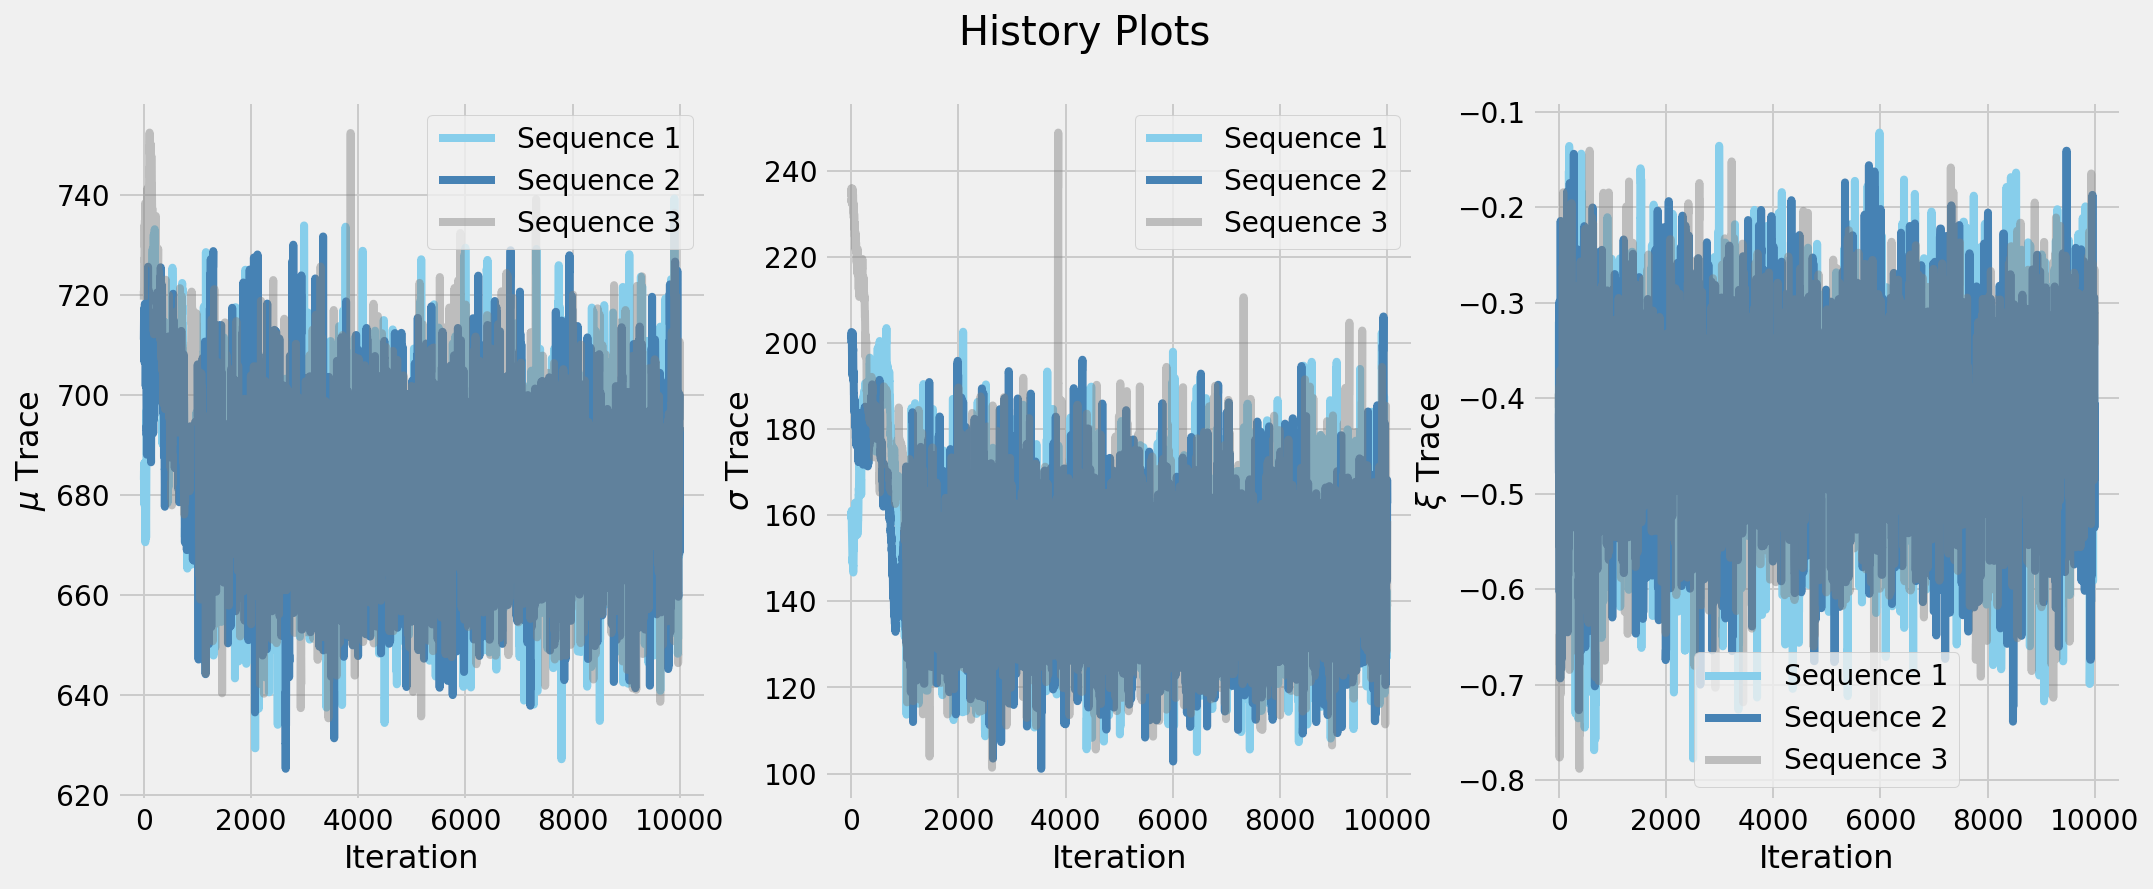

In [8]:
history_plots(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"])

***

<a id='gr-diagnostic'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic Results</h2>

[Back to top](#top)

<br>

<span style="color:red">**TW:**
Adding language that reviews the fact that we calculate burn-in using GR diagnostics.
</span>

Then, we can determine the burn in period using the Gelman and Rubin diagnostics (potential scale reduction factor; Gelman and Rubin, 1992), so that we use for analysis only the part of the Markov chains once they have reached the stationary distribution.

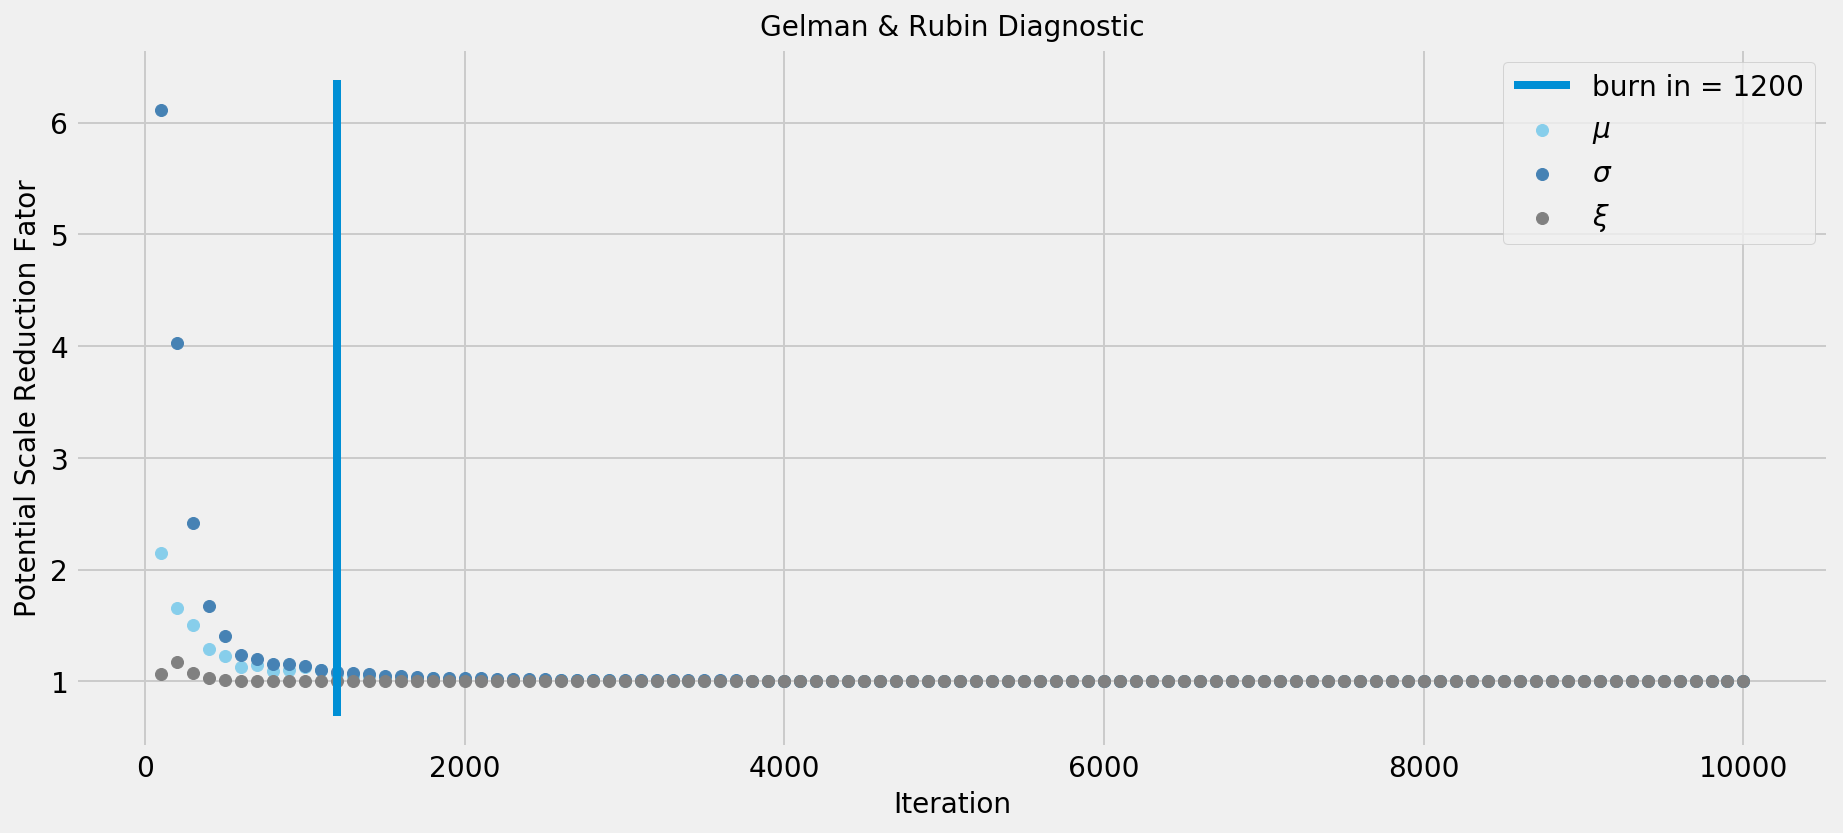

In [9]:
burnin = GR_result(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], t)

***

<a id='ac-function'></a>
***
<h2 align="center">Auto Correlation Function Results</h2>

[Back to top](#top)

<br>

Once we have the burn in period, we need to determine the lag for each sequence, we do this because we want independent draws from stationary distribution. As in the previous chapters, we can do this using the autocorrelation function (ACF), which we loaded as part of the helper functions.

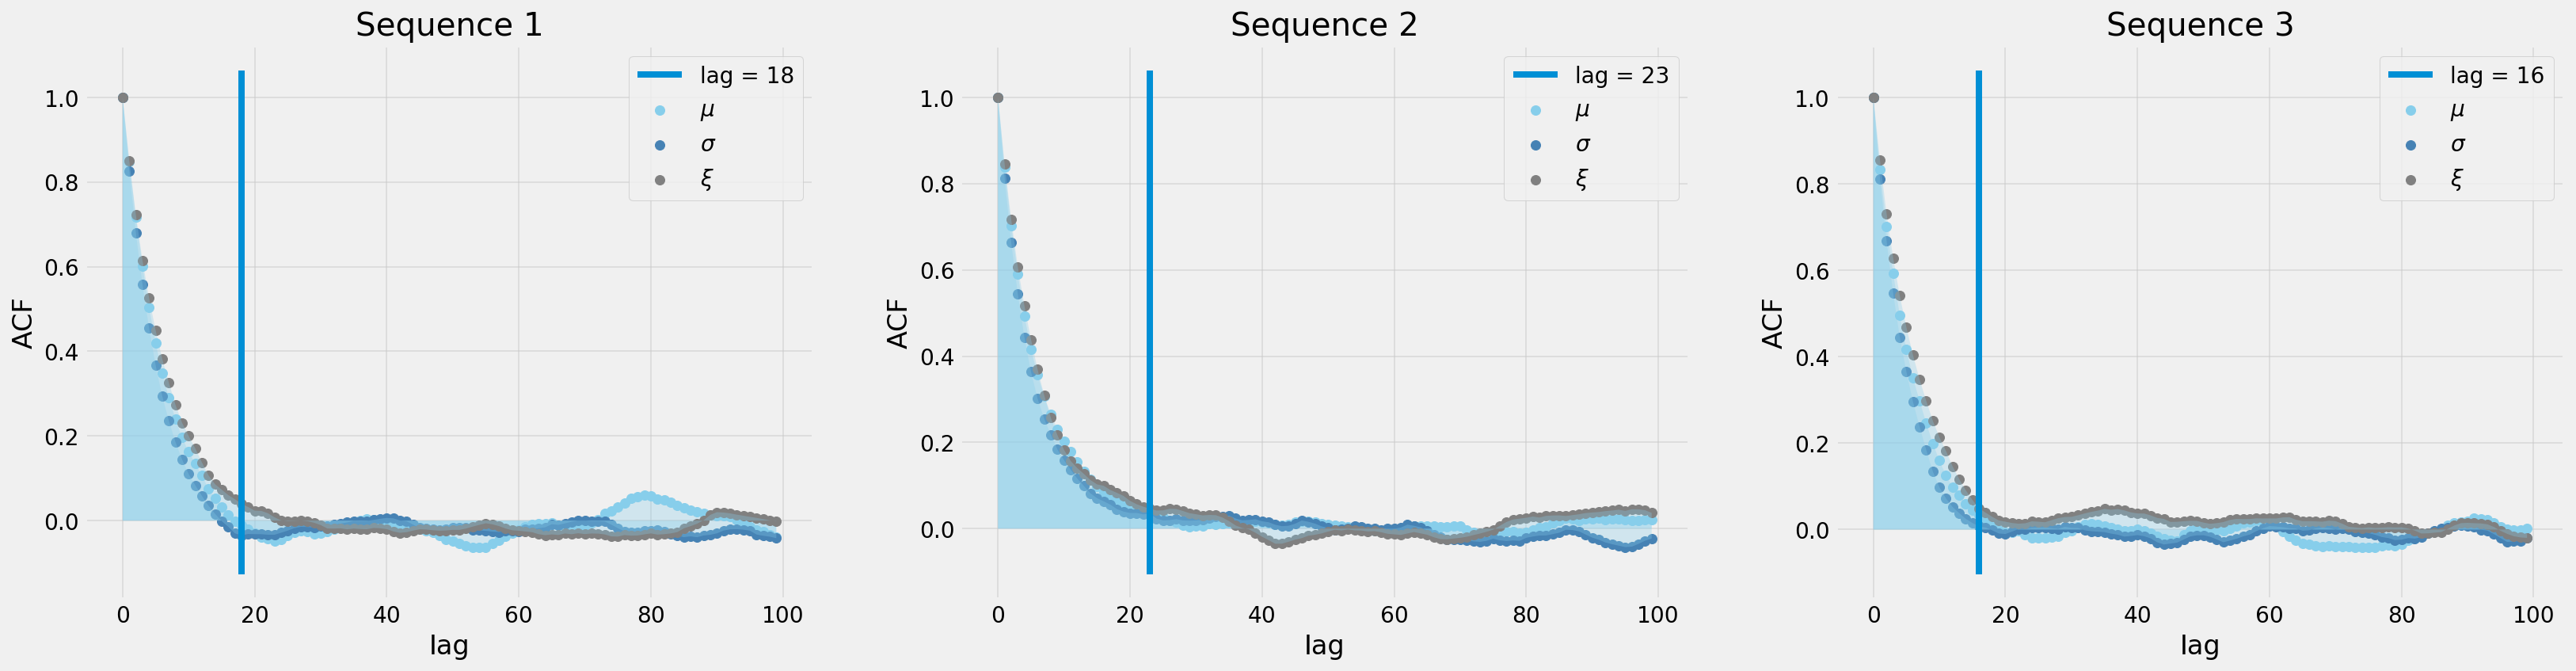

In [10]:
lags = acf_result(mcmc_chains, [r"$\mu$", r"$\sigma$", r"$\xi$"], burnin)

***

<a id='histograms'></a>
***
<h2 align="center">Density Plot For Each Parameter</h2>

[Back to top](#top)

<br>

<span style="color:gray">**TW:**
Suggested edit:  "After we have removed the burn-in period and thinned the Markov chains, we can create a pool..."
</span>

<span style="color:blue">**JL:** DONE</span>

After we have removed the burn-in period and thinned the Markov chains, we can create a pool of parameter sets, and plot the density plot for each parameter:

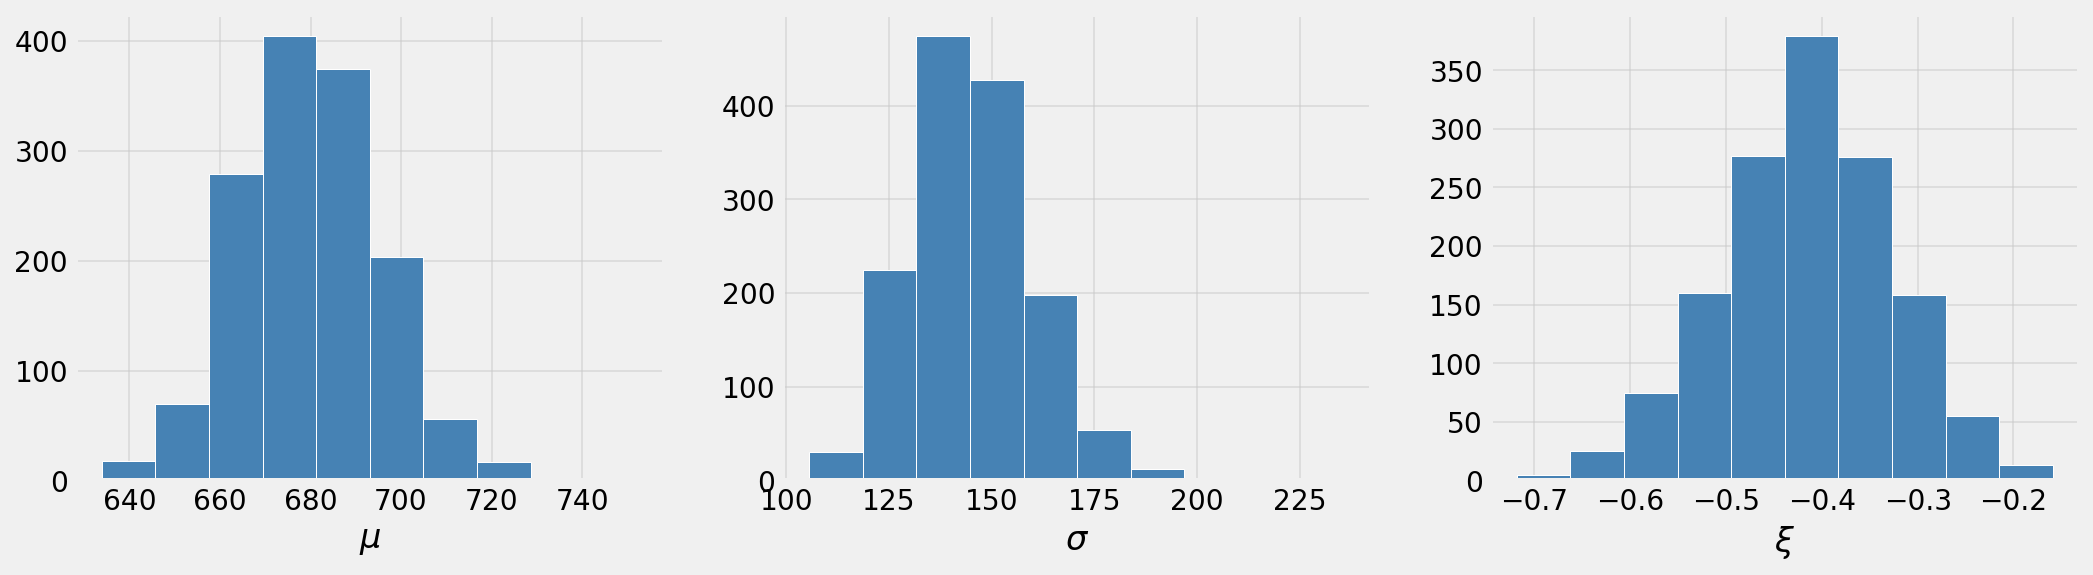

In [24]:
params_analysis = final_params_pool(mcmc_chains, burnin, lags, [r"$\mu$", r"$\sigma$", r"$\xi$"])

***

<a id='max-ls'></a>
***
<h2 align="center">Max Log-Posterior Score Parameter Set</h2>

[Back to top](#top)

<br>

Like we mentioned in previous chapters, we might be interested in checking out the maximum posterior score parameter set, because it represents the best parameters estimation we can get for this data set in our 3 markov chains, we can use this parameter set to do a lot of interesting analysis for the storm surge!

In [42]:
max_params = max_ls_parameters(ls, mcmc_chains)

The max log-posterior score parameter set is location = 678.059, scale = 140.264, shape = -0.423


***

<a id='diag-plots'></a>
***
<h2 align="center">Diagnostic Plots</h2>

[Back to top](#top)

<br>

<span style='color:red'>**TW:**
Need to describe these plots again, re-introduce them, and segue from the last section.
<span>

In [43]:
RP = np.arange(1, 501, 1)
RL = []
RL_max = []
percentile_95 = []
percentile_5 = []
percentile_995 = []
percentile_05 = []
for i in range(len(RP)):
    RL.append([])
    RL_max.append(stats.genextreme.ppf(q=(1-1/RP[i]), c=max_params[2], loc=max_params[0], scale=max_params[1]))
    for j in range(len(params_analysis)):
        RL[i].append(stats.genextreme.ppf(q=(1-1/RP[i]), c=params_analysis[j][2], loc=params_analysis[j][0], scale=params_analysis[j][1]))
for i in range(len(RL)):
    percentile_95.append(np.percentile((RL[i]), 95))
    percentile_5.append(np.percentile((RL[i]), 5))
    percentile_995.append(np.percentile((RL[i]), 99.5))
    percentile_05.append(np.percentile((RL[i]), 0.5))
    
empirical = [stats.genextreme.ppf(q=(i+1)/(len(data_meas)+1), c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
cdf = [stats.genextreme.cdf(x=np.sort(data_meas)[i], c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
x_range = np.arange(0, max(data_meas)+1, 0.5)
y_range = [stats.genextreme.pdf(x=xi, c=max_params[2], loc=max_params[0], scale=max_params[1]) for xi in x_range]

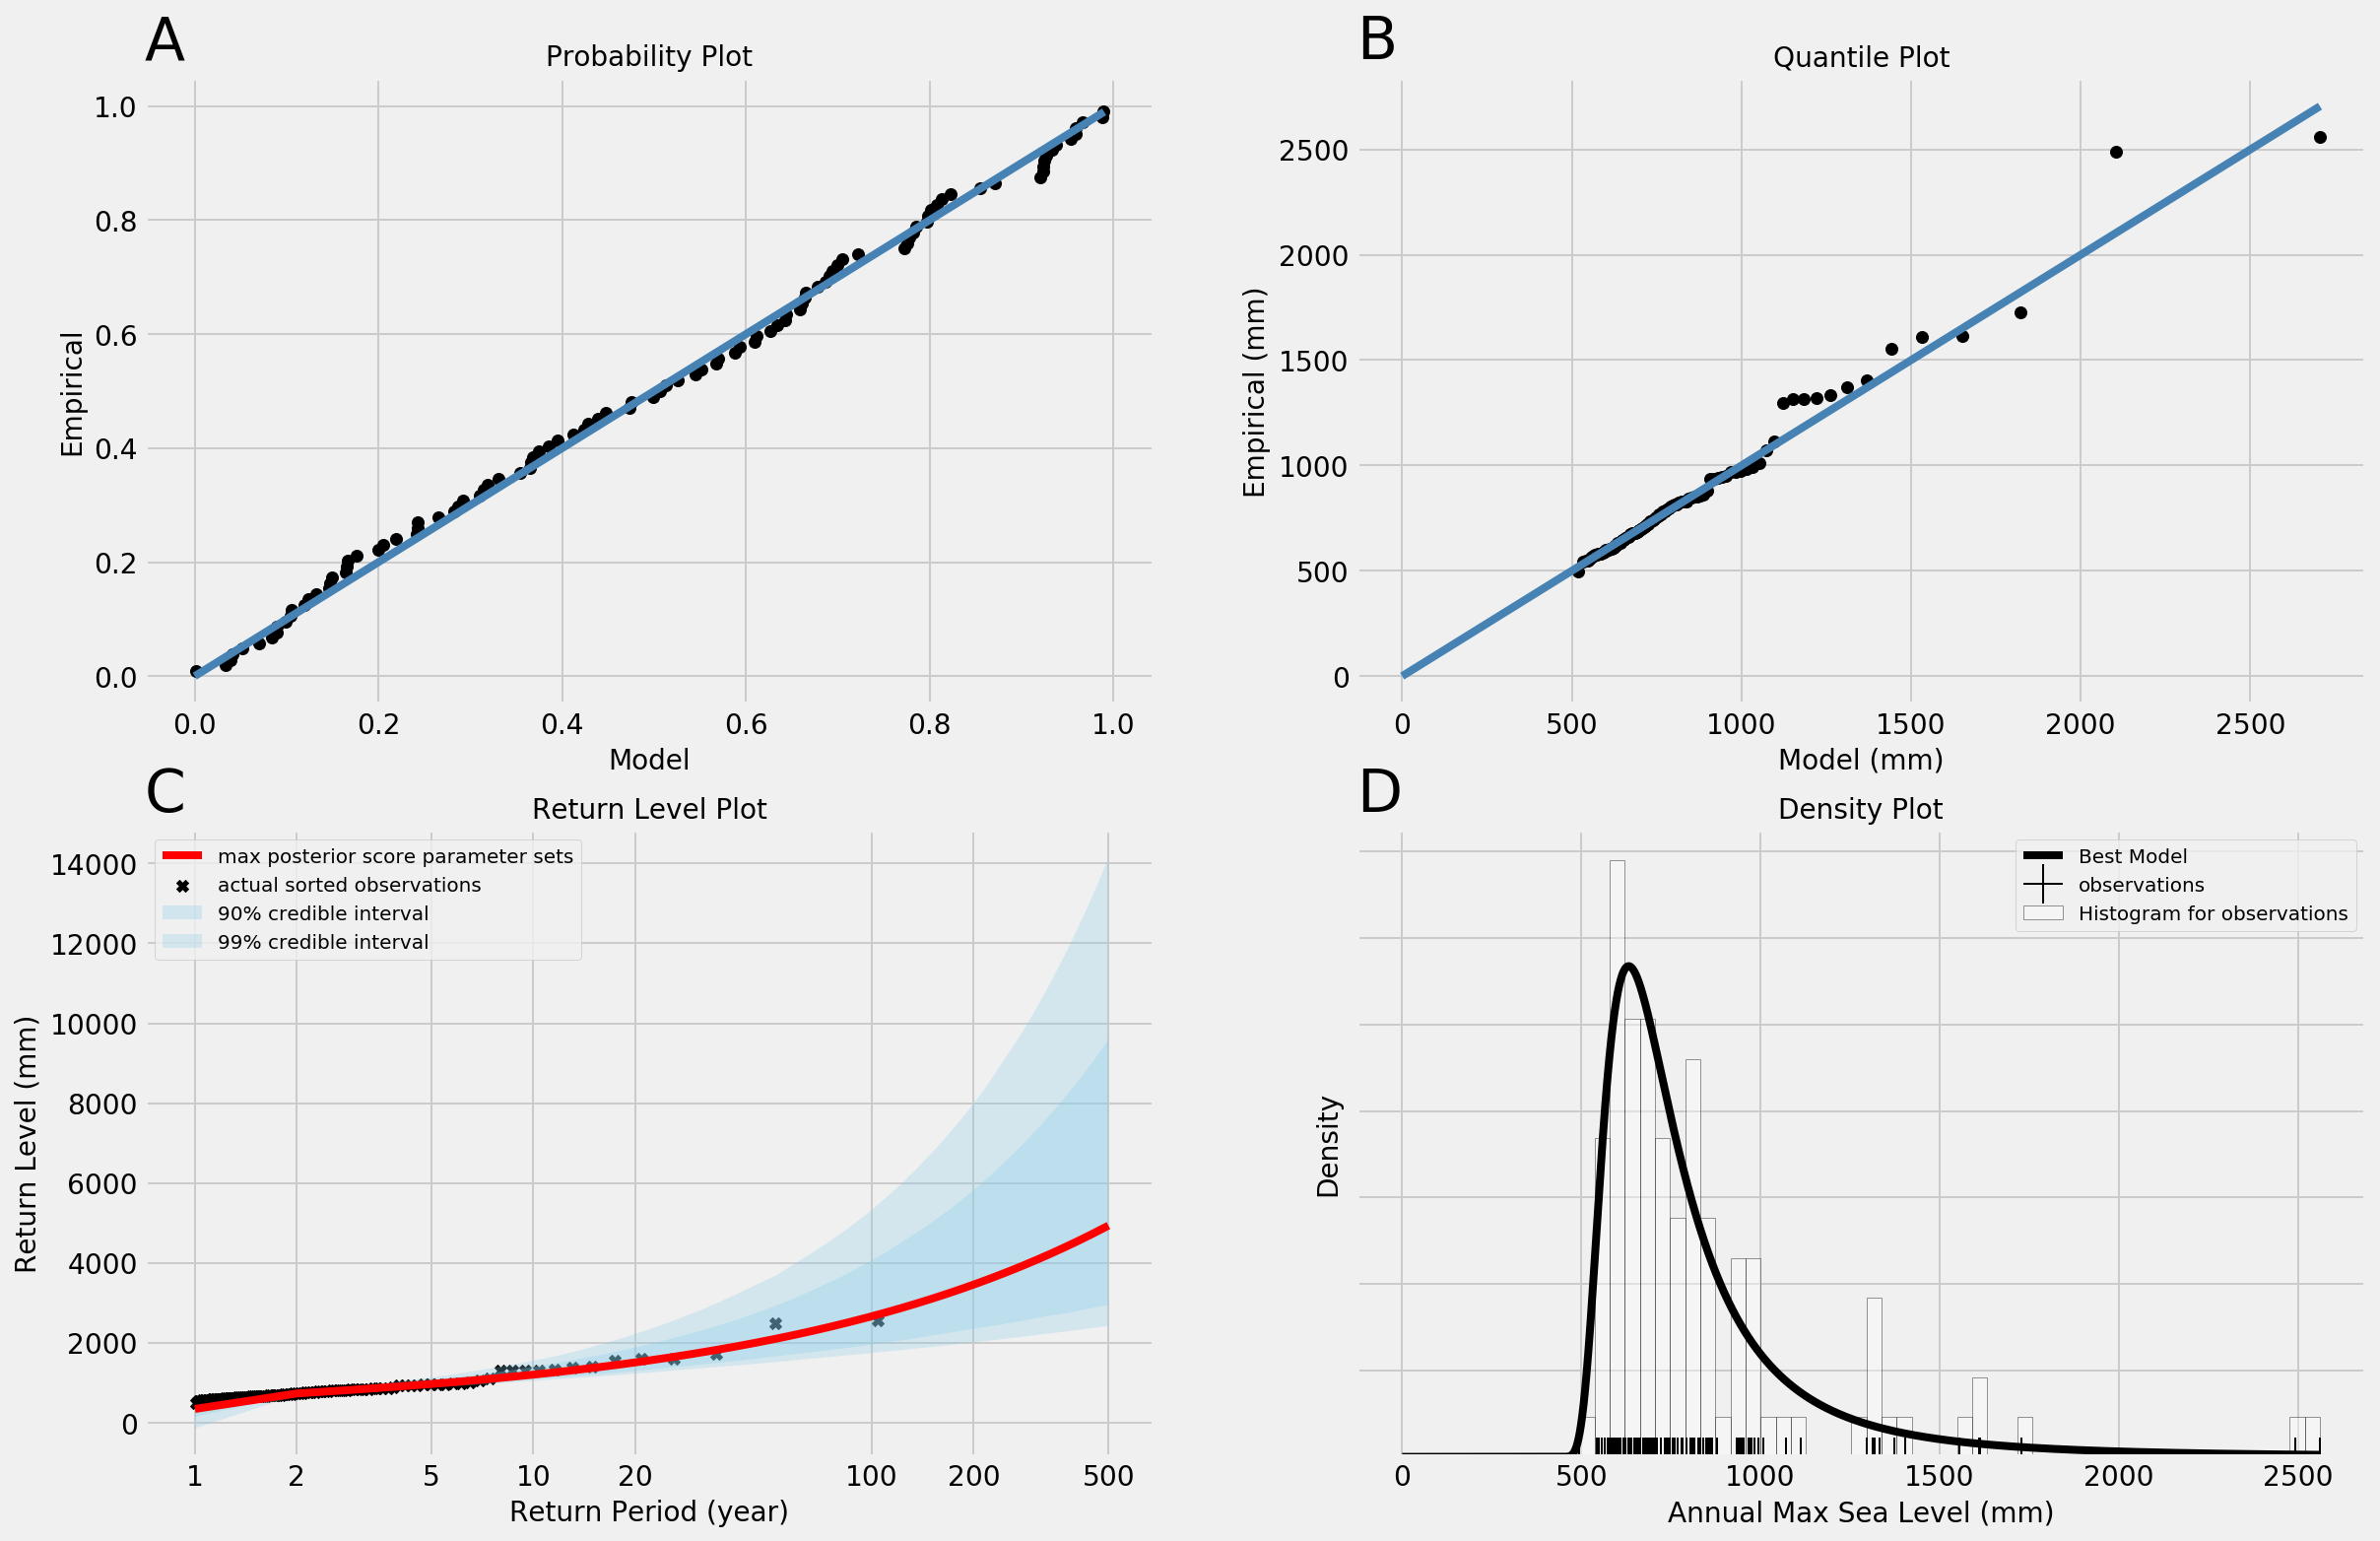

In [46]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(18,12))

ax[0,0].scatter(cdf, [(i+1)/(len(data_meas)+1) for i in range(len(data_meas))], color='black')
ax[0,0].plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), color='steelblue')
ax[0,0].set_title('Probability Plot', fontsize=14)
ax[0,0].set_xlabel('Model', fontsize=14)
ax[0,0].set_ylabel('Empirical', fontsize=14)
ax[0,0].annotate("A", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

ax[0,1].scatter(empirical, np.sort(data_meas), color='black')
ax[0,1].plot(np.arange(0, max(empirical)), np.arange(0, max(empirical)), color='steelblue')
ax[0,1].set_title('Quantile Plot', fontsize=14)
ax[0,1].set_xlabel('Model (mm)', fontsize=14)
ax[0,1].set_ylabel('Empirical (mm)', fontsize=14)
ax[0,1].annotate("B", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

ax[1,0].plot(np.log10(RP), RL_max, color='r', label='max posterior score parameter sets')
ax[1,0].scatter(np.log10([(len(data_meas)+1)/(len(data_meas)+1-k) for k in np.arange(1, len(data_meas)+1, 1)]), np.sort(data_meas), label='actual sorted observations', color='black', marker='X')
ax[1,0].fill_between(x=np.log10(RP), y1=percentile_95, y2=percentile_5, alpha=0.3, label='90% credible interval', facecolor='skyblue')
ax[1,0].fill_between(x=np.log10(RP), y1=percentile_995, y2=percentile_05, alpha=0.27, label='99% credible interval', facecolor='skyblue')
ax[1,0].legend(loc='upper left', fontsize=10)
ax[1,0].set_xticks(np.log10([1,2,5,10,20,100,200,500]))
ax[1,0].set_xticklabels([1,2,5,10,20,100,200,500])
ax[1,0].set_title('Return Level Plot', fontsize=14)
ax[1,0].set_xlabel('Return Period (year)', fontsize=14)
ax[1,0].set_ylabel('Return Level (mm)', fontsize=14)
ax[1,0].annotate("C", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

ax[1,1].hist(data_meas, bins=np.linspace(min(data_meas), max(data_meas)), normed=True, edgecolor='black', label='Histogram for observations', color='white', alpha=0.4)
ax[1,1].plot(x_range, y_range, label='Best Model', color='black')
ax[1,1].plot(data_meas, np.zeros_like(data_meas), 'b+', ms=20, color='black', label='observations')
ax[1,1].legend(loc='best', fontsize=10)
ax[1,1].set_yticklabels([])
ax[1,1].set_title('Density Plot', fontsize=14)
ax[1,1].set_xlabel('Annual Max Sea Level (mm)', fontsize=14)
ax[1,1].set_ylabel('Density', fontsize=14)
ax[1,1].annotate("D", xy=(0.0, 1.03), xycoords="axes fraction", fontsize=30)

plt.show()

<span style='color:red'>**TW:**
Include a section that discusses the implications of these results, and mentions each of the four panels by name. the abbreviation for millimeters ought to be "mm" and you can simply write (e.g.) "Return level (mm)" instead of "in mm". Address in the text things like how well the model fits the data, and how this depends on which quantiles we are trying to examine. Address how wide the uncertainty range is in panel C for example. Also we will want to bring up what are credible intervals! Panel C might not be intuitive to everyone because the distribution of return levels corresponding to a particular return period is coming out of the figure towards the viewer.
$$$$
Include some wrap-up conclusions text.
<span>

***

<a id='packages'></a>
***
<h2 align="center">Packages and Helper Functions</h2>

[Back to top](#top)

<br>

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
plt.style.use("seaborn")
COLORS = ["skyblue", "steelblue", "gray"]
ALPHAS = [1.0, 1.0, 0.45]

def loglikelihood(parameters, data_meas):
    mu, sigma, shape = parameters
    s = 0
    for i in range(len(data_meas)):
        logpdf = stats.genextreme.logpdf(x=data_meas[i], loc=mu, scale=sigma, c=shape)
        if logpdf == -np.inf:
            return -np.inf
        s += logpdf
    return s

def logprior(parameters):
    mu, sigma, shape = parameters
    mu_logpdf = stats.norm.logpdf(x=mu, loc=0, scale=1000)
    shape_logpdf = stats.norm.logpdf(x=shape, loc=0, scale=1000)
    if sigma >= 10000 or sigma <= 0:
        return -np.inf
    else:
        return mu_logpdf + np.log(1 / 10000) + shape_logpdf
    
def logpost(parameters, data_meas):
    pi = logprior(parameters)
    if pi == -np.inf:
        return -np.inf
    LL = loglikelihood(parameters, data_meas)
    return LL + pi

def update_mean(m, X):
    N = len(X[0])
    n = []
    for i in range(len(m)):
        n.append([(m[i][0]*(N-1) + X[i][-1])/N])
    return np.array(n)

def update_cov(X, m, Ct, Sd, Id, eps):
    m1 = update_mean(m, X)
    t = len(X[0])-1
    part1 = ((t-1)/t)*Ct
    part2 = t*np.matmul(m, np.transpose(m))
    part3 = (t+1)*np.matmul(m1, np.transpose(m1))
    Xt = []
    Xt.append(X[:,-1])
    part4 = np.matmul(np.transpose(Xt), Xt)
    part5 = eps*Id
    cov = part1 + (Sd/t)*(part2 - part3 + part4 + part5)
    return (cov + np.transpose(cov))/2, m1

def random_move(current_state, X, Ct, t, t0, stepsize, data_meas, logpost, m, S_d, I_d):
    if (t <= t0):
        next_move = stats.multivariate_normal.rvs(current_state, stepsize)
        return next_move, logpost(next_move, data_meas), m, stepsize
    elif (t == t0 + 1):
        n = []
        for i in range(len(X)):
            n.append([np.mean(X[i])])
        cov = S_d*np.cov(X) + I_d*0.0001*S_d
        next_move = stats.multivariate_normal.rvs(current_state, cov)
        return next_move, logpost(next_move, data_meas), n, cov
    else:
        cov, m1 = update_cov(X, m, Ct, S_d, I_d, 0.0001)
        next_move = stats.multivariate_normal.rvs(current_state, cov)
        return next_move, logpost(next_move, data_meas), m1, cov
    
def adaptivemcmc(initial_state, n_iter, stepsize, data_meas, logpost, t0):
    d = len(initial_state)
    I_d = np.identity(d)
    S_d = (2.4)**2/d
    parameters = []
    current_state = initial_state
    current_value = logpost(initial_state, data_meas)
    for i in range(d):
        parameters.append([])
        parameters[i].append(initial_state[i])
    lpost = [current_value]    
    n_accept = 0
    S = 0
    np.seterr(over='ignore')
    cov = stepsize
    m = []
    for t in range(n_iter):
        S += 1
        nextMove, nextValue, m, cov = random_move(current_state, np.array(parameters), cov, t, t0, stepsize, data_meas, logpost,m, S_d, I_d)
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            n_accept += 1
            for i in range(d):
                parameters[i].append(nextMove[i])
            lpost.append(nextValue)
            current_state = nextMove
            current_value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1-p_accept])
            if accept:
                n_accept += 1
                for i in range(d):
                    parameters[i].append(nextMove[i])
                lpost.append(nextValue)
                current_state = nextMove
                current_value = nextValue
            else:
                for i in range(d):
                    parameters[i].append(parameters[i][-1])
                lpost.append(lpost[-1])
    return (parameters, lpost, n_accept/S)

def sequences_generator(m, n_iter, data_meas, logpost, t=1000, stepsize=[10, 2, 0.01]):
    np.seterr(divide='ignore', invalid='ignore')
    loc_est = np.median(data_meas)
    scale_est = (np.percentile(data_meas, 75) - np.percentile(data_meas, 25))/2
    shape_est = 0
    gevfit = stats.genextreme.fit(data_meas, loc=loc_est, scale=scale_est)
    
    if logpost([gevfit[1], gevfit[2], gevfit[0]], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = gevfit[1], gevfit[2], gevfit[0]
        
    elif logpost([loc_est, scale_est, -0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, -0.1
        
    elif logpost([loc_est, scale_est, 0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0.1
        
    else:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0
        
    problems = []
    for i in range(m):
        ui = np.random.randint(low=loc_est, high=loc_est+100)
        si = np.random.randint(low=scale_est, high=scale_est+100)
        shapei = shape_est
        theta =[ui, si, shapei]
        problems.append(theta)
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        parameters, l, r = adaptivemcmc(problems[i], n_iter, stepsize, data_meas, logpost, t)
        mcmc_chains.append(parameters)
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

def history_plots(mcmc_chains, params, true_params=None):
    m = len(mcmc_chains)
    fig, ax = plt.subplots(nrows=1, ncols=len(params), figsize=(16, 6))
    fig.suptitle("History Plots", fontsize=20)
    for i in range(len(params)):
        for j in range(m):
            ax[i].plot(
                mcmc_chains[j][i],
                label="Sequence {0}".format(j + 1),
                color=COLORS[j % 3],
                alpha=ALPHAS[j % 3],
            )
        if true_params is not None:
            ax[i].plot(
                ax[i].get_xbound(),
                [true_params[i], true_params[i]],
                color="black",
                linestyle="dashed",
                label=params[i] + " true value",
                linewidth=2.5,
            )
        ax[i].set_xlabel("Iteration", fontsize=16)
        ax[i].set_ylabel(params[i] + " Trace", fontsize=16)
        ax[i].legend(loc="best")
    plt.show()
    
def GR_diag(parameter, interval=100, start=100):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    for n in range(start, end, interval):
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i+1
            break
    return GR_result, burnin*interval

def psrf(sequences):
    u = [np.mean(sequence) for sequence in sequences]
    s = [np.var(sequence, ddof=1) for sequence in sequences]
    m = len(sequences)
    n = len(sequences[0])
    U = np.mean(u)
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - U)**2
        W += s[i]
    B = (B*n)/(m-1)
    W = W/m
    Var = (1-(1/n))*W + (B/n)
    return np.sqrt(Var/W)

def GR_result(mcmc_chains, params, t, start=100, interval=100, plot=True):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_raw, GR_params, burnin_params = [], [], []
    start, interval, end = start, interval, n
    for i in range(d):
        params_raw.append([])
        for j in range(m):
            params_raw[i].append(mcmc_chains[j][i])
    for i in range(d):
        GR, burnin = GR_diag(params_raw[i], interval, start)
        GR_params.append(GR)
        burnin_params.append(burnin)
    burnin = max(max(burnin_params), t)
    if plot:
        plt.figure(figsize=(14, 6))
        for i in range(d):
            plt.scatter(x=np.arange(start, end, interval), y=GR_params[i], label=params[i], color=COLORS[i % 3])
        plt.plot([burnin, burnin], plt.ylim(), label='burn in = {0}'.format(burnin))
        plt.xlabel('Iteration', fontsize=14)
        plt.ylabel('Potential Scale Reduction Fator', fontsize=14)
        plt.title('Gelman & Rubin Diagnostic', fontsize=14)
        plt.legend(loc='best')
        plt.show()
    return burnin

def ACF(X, end=200):
    N = len(X)
    acf = []
    for a in range(0, end):
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
        
    lag = -1
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if lag == -1:
        print ('Please increase the value of the end parameter for this function')
    return lag, acf

def acf_result(mcmc_chains, params, burnin, plot=True):
    lag_params, acf_params = [], []
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    end = 100
    for i in range(d):
        lag_params.append([])
        acf_params.append([])
        for j in range(m):
            lag, acf = ACF(mcmc_chains[j][i][burnin:], end)
            lag_params[i].append(lag)
            acf_params[i].append(acf)
    lags = [max(np.array(lag_params)[:,i]) for i in range(m)]
    
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=m, figsize=(25,6))
        for i in range(m):
            for j in range(d):
                ax[i].scatter(np.arange(0, end), acf_params[j][i], label=params[j], color=COLORS[j % 3])
                ax[i].fill_between(x=np.arange(0, end), y2=np.zeros_like(acf_params[j][i]), y1=acf_params[j][i], alpha=0.3, facecolor='skyblue')
            ax[i].plot([lags[i],lags[i]], ax[i].get_ylim(), label='lag = {0}'.format(lags[i]))
            ax[i].set_xlabel("Iag")
            ax[i].set_ylabel("ACF")
            ax[i].set_title("Sequence {0}".format(i+1))
            ax[i].legend(loc='best')
            ax[i].grid(alpha=0.5)
        plt.show()
    return lags

def final_params_pool(mcmc_chains, burnin, lags, params, plot=True):
    m, d, n = len(mcmc_chains), len(mcmc_chains[0]), len(mcmc_chains[0][0])
    params_pool, params_ana = [], [[] for i in range(d)]
    for i in range(m):
        for j in range(burnin, n, lags[i]):
            params_pool.append([])
            for k in range(d):
                params_ana[k].append(mcmc_chains[i][k][j])
                params_pool[-1].append(mcmc_chains[i][k][j])
            
    if plot:
        fig, ax = plt.subplots(nrows=1, ncols=d, figsize=(16,4))
        for i in range(d):
            ax[i].hist(params_ana[i], color="steelblue", edgecolor='white')
            ax[i].set_xlabel(params[i])
            ax[i].grid(alpha=0.5)
        plt.show()  
    return params_pool

def max_ls_parameters(ls, mcmc_chains):
    max_indices = []
    maxs = []
    for i in range(len(mcmc_chains)):
        max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
        maxs.append(np.array(ls[i]).max())
    seqi = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
    iterj = max_indices[seqi]
    max_params = []
    d = len(mcmc_chains[0])
    for i in range(d):
        max_params.append(mcmc_chains[seqi][i][iterj])
    print ('The max log-posterior score parameter set is location = {:.3f}, scale = {:.3f}, shape = {:.3f}'.format(max_params[0],max_params[1],max_params[2]))
    return max_params

[Back to top](#top)